<a href="https://colab.research.google.com/github/rubengamarro/practicas_aprendizaje_no_supervisado/blob/main/1_Agrupamiento_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EJERCICIO 1

In [6]:
from PIL import Image
import numpy as np
# Cargar imagen
img = Image.open('BaboonSOFM.tif')
# Convertir objeto imagen a array numpy
imagen = np.asarray(img)
#Obtenemos número de filas, columnas y canales de color
fil = imagen.shape[0]
col = imagen.shape[1]
canales = imagen.shape[2]
#Aplanamos array de imagen para pasar a una lista de filxcol muestras con
#tantos rasgos como canales tenga la imagen
X = imagen.reshape((fil*col, canales))

**Apartado a**

In [7]:
from sklearn.cluster import KMeans

#init='randon' especifica el algoritmo "clásico" de K-medias
km = KMeans(n_clusters=8,
            init='random',
            n_init='auto',
            random_state=0)
predicciones = km.fit_predict(X)

**Apartado b**

In [8]:
imagenComp = np.zeros((fil,col,canales))
cont=0
for idx_f in np.arange(fil):
  for idx_c in np.arange(col):
    imagenComp[idx_f, idx_c, :] = km.cluster_centers_[predicciones[cont]]
    cont=cont+1

**Apartado c**

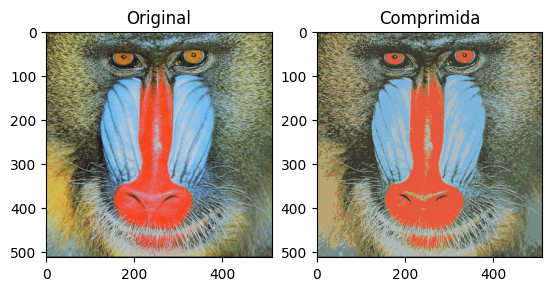

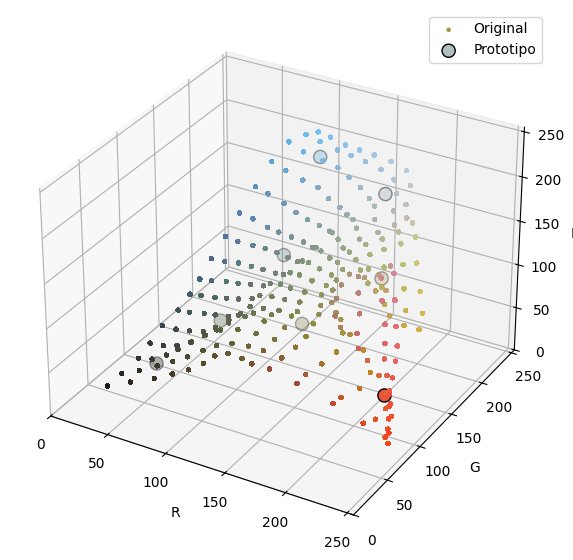

In [9]:
import matplotlib.pyplot as plt
#Dibujamos la imagen original y la comprimida
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imagen)
ax1.set_title('Original')
#Debemos pasar a entero para que se dibuje correctamente
ax2.imshow(imagenComp.astype(np.int32))
ax2.set_title('Comprimida')
plt.show()

fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='.', color=X/255, label='Original')
ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],
km.cluster_centers_[:,2], marker='o', edgecolor='k',
color=km.cluster_centers_/255, s=90,label='Prototipo')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.legend()
ax.axes.set_xlim3d(left=0, right=255)
ax.axes.set_ylim3d(bottom=0, top=255)
ax.axes.set_zlim3d(bottom=0, top=255)
plt.show()

**Apartado d**

En la imagen comprimida se utilizan 8 colores distintos, que se corresponden a los 8 centroides que le hemos pedido a k-medias.

#EJERCICIO 2

**Apartado a**

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://github.com/rubengamarro/practicas_aprendizaje_no_supervisado/raw/main/data/urbanGB.csv', header=None)
df

,0,1
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594
...,...,...
360172,-0.557803,53.2197
360173,-1.748430,52.4872
360174,-0.128844,51.5126
360175,-1.885640,52.4490


In [11]:
from sklearn.preprocessing import StandardScaler

X_accidentes = df.values

escaladorEstandar = StandardScaler()
X_accidentes_std = escaladorEstandar.fit_transform(X_accidentes)

df_accidentes_std = pd.DataFrame(X_accidentes_std, columns=df.columns)

Text(0, 0.5, 'X1')

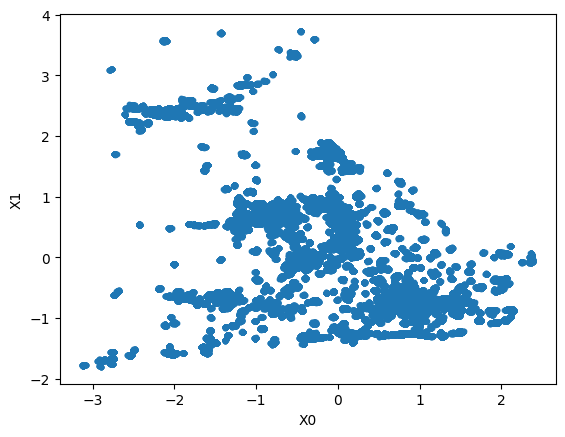

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(X_accidentes_std[:,0], X_accidentes_std[:,1], s=10)
plt.xlabel("X0")
plt.ylabel("X1")

In [13]:
km_plus = KMeans(n_clusters=5,
            init='k-means++',
            n_init='auto',
            random_state=0)
predicciones = km_plus.fit_predict(X_accidentes_std)
predicciones

array([4, 0, 1, ..., 1, 4, 0], dtype=int32)

In [14]:
from numpy import unique
from matplotlib import cm

def dibujaMuestras2D(X, predicciones, centroides = []):
  #Obtenemos lista de identificadores de grupos
  grupos = unique(predicciones)
  #Definimos los colores para las muestras de cada grupo

  colores = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(grupos))]

  #Procesamos muestras grupo a grupo:
  for grupo, color in zip(grupos, colores):
    etiqueta = "Grupo " + str(grupo)
    plt.scatter(X[predicciones==grupo, 0], X[predicciones==grupo, 1], s=20,
                  color=color, label=etiqueta)

  if len(centroides)!= 0:
    #Dibujamos centroides:
    plt.scatter(centroides[:, 0], centroides[:, 1],
                c="r", marker = "X", label="Centroides",
                s=200)

  #Dibujamos leyenda, etiquetas...
  plt.xlabel("X0")
  plt.ylabel("X1")
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

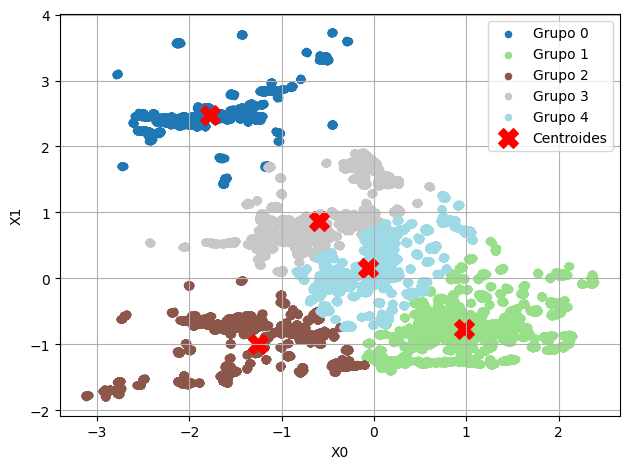

In [15]:
dibujaMuestras2D(X_accidentes_std, predicciones, km_plus.cluster_centers_)

Los distintos centroides serán las nuevas comisarías y los puntos de cada color son los distintos accidentes provocados en las 5 zonas distintas.

**Apartado b**

In [16]:
from sklearn.utils import resample
X_red = resample(X_accidentes, n_samples=5000,random_state=0)

X_red_std = StandardScaler().fit_transform(X_red)

In [17]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=50).fit(X_red_std)
predicciones = db.labels_

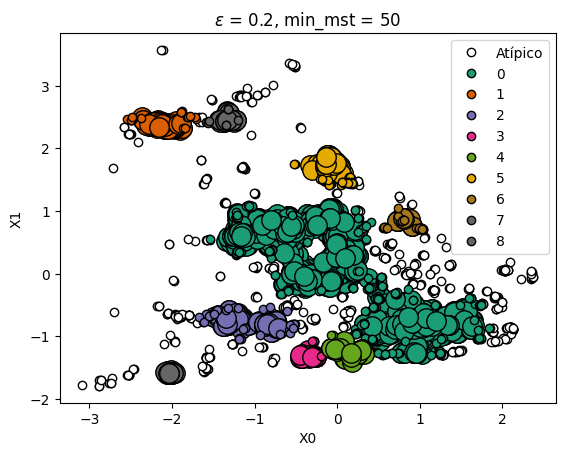

In [18]:
grupos = np.unique(predicciones)
mascara_m_nucleos = np.zeros_like(predicciones, dtype=bool)
mascara_m_nucleos[db.core_sample_indices_] = True

colores = [plt.cm.Dark2(each) for each in np.linspace(0, 1, len(grupos))]
#Iteramos grupo a grupo:
for k, color in zip(grupos, colores):
    if (k == -1):
        # Muestras atípicas en color blanco
        color = 'white'
        etiqueta = 'Atípico'
    else:
        etiqueta = k
    mascara_grupo_act = (predicciones == k)

    #Dibujamos muestras núcleo grupo actual
    X_grupo_act = X_red_std[mascara_grupo_act & mascara_m_nucleos]
    plt.plot(
        X_grupo_act[:, 0],
        X_grupo_act[:, 1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=14)

    #Dibujamos muestras frontera grupo actual o atípicas si es grupo -1
    X_grupo_act = X_red_std[mascara_grupo_act & ~mascara_m_nucleos]
    plt.plot(
        X_grupo_act[:, 0],
        X_grupo_act[:, 1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
        label=etiqueta)

plt.xlabel("X0")
plt.ylabel("X1")
plt.legend()
plt.title(f"$\epsilon$ = {db.eps}, min_mst = {db.min_samples} ")
plt.show()

Los puntos coloreados estarán vigilados por drones, mientras que los puntos blancos no serán vigilados dado que no llegan a los accidentes mínimos en esa zona. Cada color marca las diferentes zonas que son vigiladas por distintos drones.

**Apartado c**

In [19]:
#Cantidad de muestras atípicas y de grupos en las predicciones
n_atipicas = list(predicciones).count(-1)
n_grupos = np.unique(predicciones).shape[0] - (1 if (n_atipicas > 0) else 0)

print("Cantidad predicha de grupos: %d" % n_grupos)
print("Cantidad predicha de muestras atípicas: %d" % n_atipicas)

Cantidad predicha de grupos: 9
Cantidad predicha de muestras atípicas: 568


Utilizaremos 9 drones, que son los distintos grupos que ha formado nuestro modelo basado en densidad, en este caso de accidentes.

#EJERCICIO 3

**Apartado a**

In [20]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://github.com/rubengamarro/practicas_aprendizaje_no_supervisado/raw/main/data/tripadvisor_review.csv')
df

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.80,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.20,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.80,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.80,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.20,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54
...,...,...,...,...,...,...,...,...,...,...,...
975,User 976,0.74,1.12,0.30,0.53,0.88,1.38,3.17,2.78,0.99,3.20
976,User 977,1.25,0.92,1.12,0.38,0.78,1.68,3.18,2.79,1.34,2.80
977,User 978,0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02
978,User 979,0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46


In [21]:
#Escalamos los datos
rasgos_numericos = df.select_dtypes(include=np.number).columns
X_std = StandardScaler().fit_transform(df[rasgos_numericos])

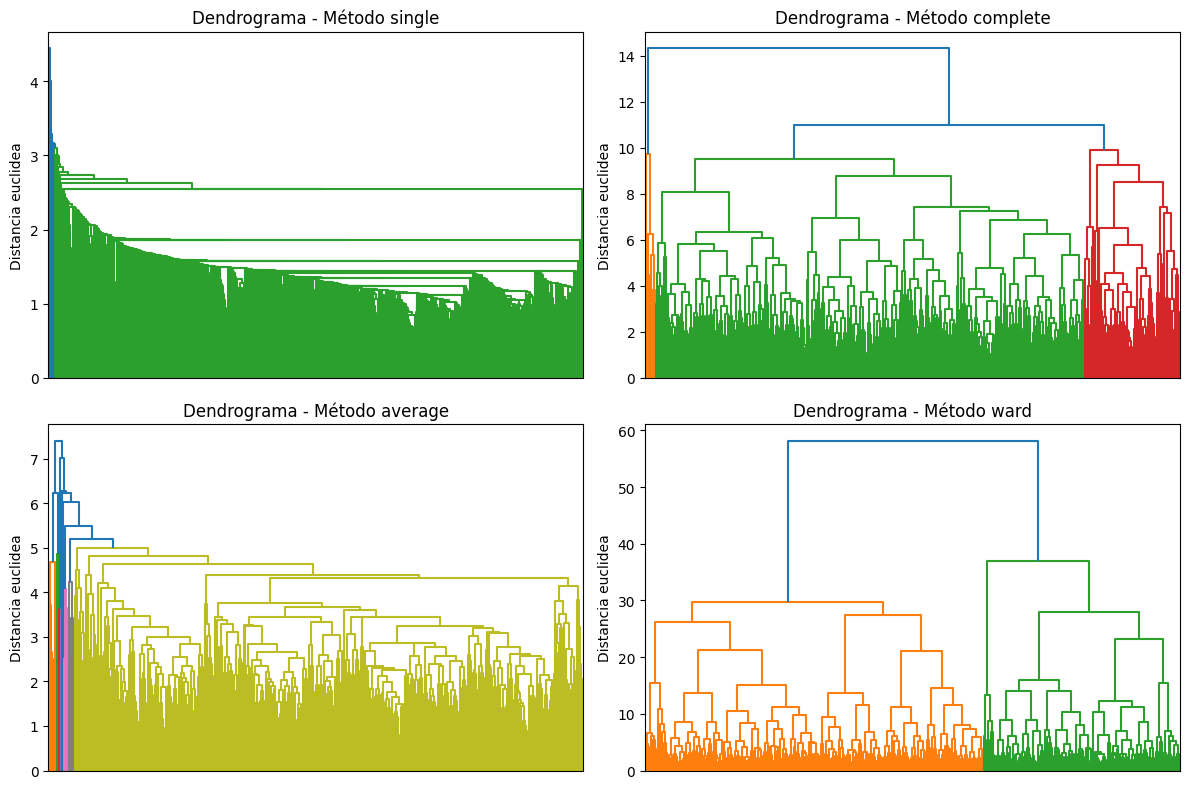

In [22]:
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

metodos = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(12, 8))
for i, metodo in enumerate(metodos):
    plt.subplot(2, 2, i+1)
    matriz_uniones = linkage(X_std, method=metodo, metric='euclidean')
    dendrogram(matriz_uniones, no_labels=True)
    plt.title(f'Dendrograma - Método {metodo}')
    plt.ylabel('Distancia euclidea')
plt.tight_layout()
plt.show()

Como podemos ver en las 4 gráficas, el método que parece más robusto es el método ward, ya que muestra una gran diferencia de distancia al unir los dos últimos grupos con respecto a los demás.

In [23]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='ward')
predicciones = ac.fit_predict(X_std)

dfPred = pd.DataFrame(predicciones, columns=["Grupo"])
dfPred

,Grupo
0,0
1,0
2,1
3,1
4,1
...,...
975,1
976,1
977,1
978,1


**Apartado b**

In [24]:
user78 = predicciones[77] #ponemos 77 ya que el User 78 se encuentra en la posicion 77 ya que se cuenta desde 0
print("El usuario 78 pertenece al grupo", user78)

El usuario 78 pertenece al grupo 0


Por tanto, los clientes que respondieron a la encuesta de forma parecida a la del 'User 78' son los que pertenecen al grupo 0.

#EJERCICIO 4

In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://github.com/rubengamarro/practicas_aprendizaje_no_supervisado/raw/main/data/Muestras3D.csv')
df

,rasgo0,rasgo1,rasgo2
0,2.964544,0.230857,-4.187989
1,2.853494,1.009440,-3.567897
2,3.070492,-0.058010,-2.451848
3,2.983127,-1.633358,3.192078
4,-2.338341,2.227477,-3.589274
...,...,...,...
995,-2.174781,0.400929,2.804425
996,2.928806,0.555132,2.127335
997,2.905729,-0.184747,2.530988
998,2.914821,1.646199,-3.432763


In [26]:
X = df.values
X_std = StandardScaler().fit_transform(X)

**Apartado a**

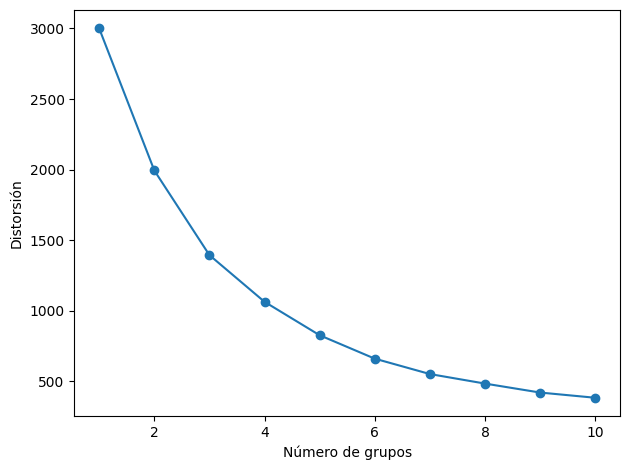

In [27]:
#Lista con las distorsiones de cada configuración
distorsion_ = []

k_max=10
for k_act in range(1, k_max+1):
    km = KMeans(n_clusters=k_act,
                init='random',
                n_init='auto',
                random_state=0)
    km.fit(X_std)
    distorsion_.append(km.inertia_)

plt.plot(range(1,11), distorsion_, marker='o')
plt.xlabel('Número de grupos')
plt.ylabel('Distorsión')
plt.tight_layout()
plt.show()

Como podemos ver, no se produce una estabilización de la distorsión, por lo que estamos ante un conjunto de muestras distribuidas de manera no hiperesférica. Por tanto el método K-medias no será una buena opción para este conjunto de muestras. No podemos determinar un número óptimo de grupos.

**Apartado b**

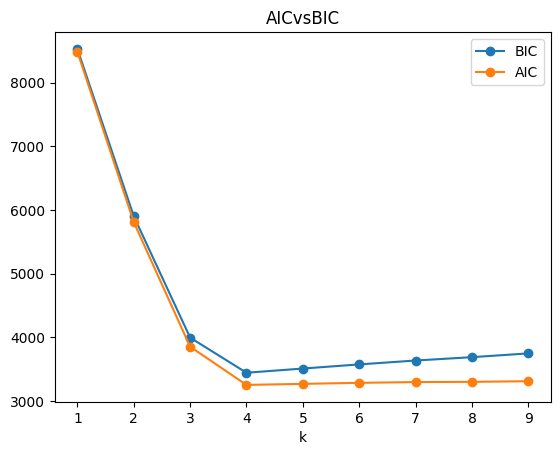

In [28]:
from sklearn.mixture import GaussianMixture

k_max = 10
rango_k = np.arange(1, k_max)
bics = []
aics = []
for k_act in rango_k:
  gmm = GaussianMixture(k_act,
                        max_iter = 1000,
                        random_state = 0).fit(X_std)
  bics.append(gmm.bic(X_std))
  aics.append(gmm.aic(X_std))

plt.plot(rango_k, bics, label = 'BIC', marker='o')
plt.plot(rango_k, aics, label = 'AIC', marker='o')

plt.xlabel('k')
plt.legend()
plt.title('AICvsBIC')

plt.show()

Como podemos ver en la gráfica, el número óptimo de grupos será 4.

**Apartado c**

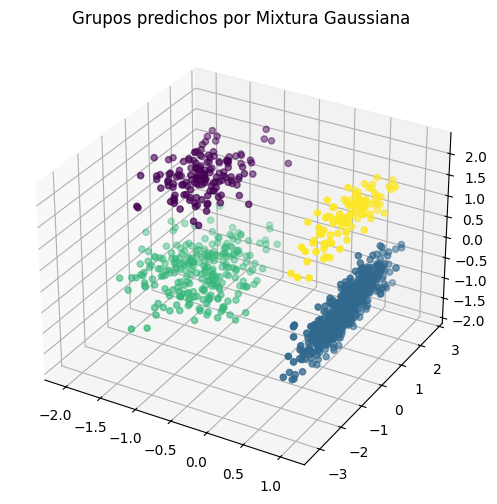

In [29]:
#Dibujamos en 3d las muestras, con cada grupo de un color

gmm = GaussianMixture(n_components=4, random_state=0)
gmm_labels = gmm.fit_predict(X)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_std[:,0], X_std[:,1], X_std[:,2], c=gmm_labels, cmap='viridis')
ax.set_title('Grupos predichos por Mixtura Gaussiana')
plt.show()

#EJERCICIO 5

**Apartado a**

In [30]:
#Cargamos todas las imágenes
imagenes = []
for i in range(1, 32):
    nombreImagen = f'fake_and_real_peppers_ms_{i:02d}.png'
    imagen = Image.open(nombreImagen)
    imagenes.append(np.asarray(imagen))

hiperimagen = np.stack(imagenes, axis=-1)
print("Forma del array multiespectral:", hiperimagen.shape)

#Obtenemos número de filas, columnas y canales de color
fil = hiperimagen.shape[0]
col = hiperimagen.shape[1]
canales = hiperimagen.shape[2]
#Aplanamos array de imagen para pasar a una lista de filxcol muestras con
#tantos rasgos como canales tenga la imagen
X = hiperimagen.reshape((fil*col, canales))

Forma del array multiespectral: (512, 512, 31)


In [31]:
#Hacemos el k-means con 4 grupos
kmeans = KMeans(n_clusters=4, init='random', n_init='auto', random_state=0)
predicciones = kmeans.fit_predict(X)

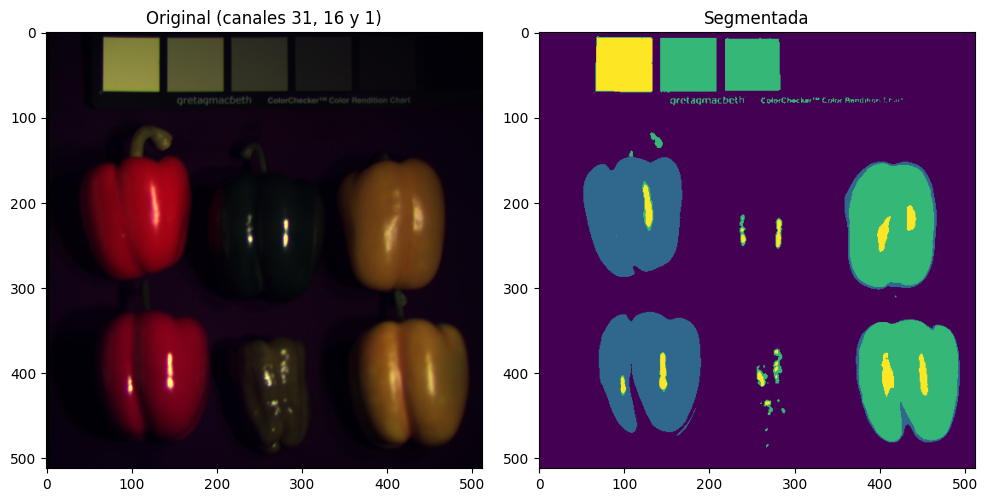

In [32]:
#Obtenemos el índice del grupo de cada píxel
imagen_indices = predicciones.reshape(512, 512)

#Mostramos las imágenes
plt.figure(figsize=(10, 5))

canal_1 = hiperimagen[:, :, 30].astype(np.float32)
canal_2 = hiperimagen[:, :, 15].astype(np.float32)
canal_3 = hiperimagen[:, :, 0].astype(np.float32)

img_rgb = np.stack((canal_1, canal_2, canal_3), axis=-1)

img_rgb -= img_rgb.min()
img_rgb /= img_rgb.max()
img_rgb *= 255.0

plt.subplot(1, 2, 1)
plt.imshow(img_rgb.astype(np.uint8))
plt.title('Original (canales 31, 16 y 1)')

plt.subplot(1, 2, 2)
plt.imshow(imagen_indices, cmap='viridis')
plt.title('Segmentada')

plt.tight_layout()
plt.show()

**Apartado b**

Como podemos ver en la imagen, el algoritmo K-medias ha segmentado la imagen multiespectral en 4 grupos de píxeles con características espectrales similares, formando así grupos significativos que representan algunos objetos como son los pimientos.

**Apartado c**

In [33]:
np.random.seed(0)
total_pixeles = X.shape[0]
indices = np.arange(total_pixeles)
np.random.shuffle(indices)

In [34]:
#Hacemos una selección del 10% de píxeles completos y 90% incompletos
n_completos = int(0.1 * total_pixeles)
indices_completos = indices[:n_completos]
indices_incompletos = indices[n_completos:]

X_completo = X[indices_completos]  #datos completos
X_incompleto = X[indices_incompletos][:, [6, 12, 18, 24]]  #solo canales 7,13,19,25

In [35]:
#Entrenamos K-means sobre los píxeles completos
kmeans_imputacion = KMeans(n_clusters=256, random_state=0)
kmeans_imputacion.fit(X_completo)
centroides = kmeans_imputacion.cluster_centers_

centroides_reduc = centroides[:, [6, 12, 18, 24]]

In [36]:
#Asignamos cada pixel incompleto a su centroide más cercano
from sklearn.metrics import pairwise_distances_argmin
idx_centroides = pairwise_distances_argmin(X_incompleto, centroides_reduc)

#Sustituimos los canales que faltan con los valores del centroide correspondiente
X_estimado = centroides[idx_centroides]

#Reconstruimos la imgaen combinando píxeles completos y estimados
X_reconstruido = np.zeros_like(X)
X_reconstruido[indices_completos] = X[indices_completos]  # píxeles originales
X_reconstruido[indices_incompletos] = X_estimado  # píxeles imputados

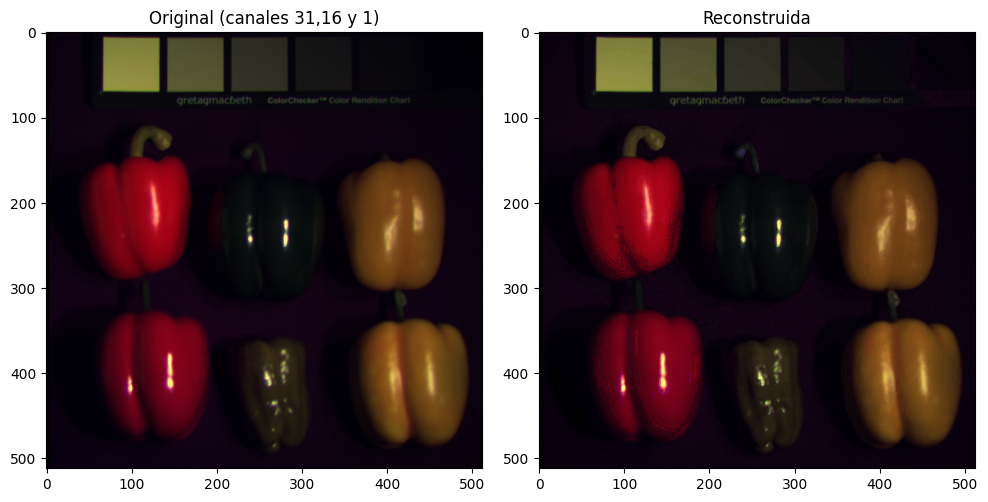

In [37]:
imagen_reconstruida = X_reconstruido.reshape(512, 512, 31)

#Original
canal_r_orig = hiperimagen[:, :, 30].astype(np.float32)
canal_g_orig = hiperimagen[:, :, 15].astype(np.float32)
canal_b_orig = hiperimagen[:, :, 0].astype(np.float32)

img_rgb_orig = np.stack((canal_r_orig, canal_g_orig, canal_b_orig), axis=-1)
img_rgb_orig -= img_rgb_orig.min()
img_rgb_orig /= img_rgb_orig.max()
img_rgb_orig *= 255.0
img_rgb_orig = img_rgb_orig.astype(np.uint8)

#Reconstruida
canal_r_est = imagen_reconstruida[:, :, 30].astype(np.float32)
canal_g_est = imagen_reconstruida[:, :, 15].astype(np.float32)
canal_b_est = imagen_reconstruida[:, :, 0].astype(np.float32)

img_rgb_est = np.stack((canal_r_est, canal_g_est, canal_b_est), axis=-1)
img_rgb_est -= img_rgb_est.min()
img_rgb_est /= img_rgb_est.max()
img_rgb_est *= 255.0
img_rgb_est = img_rgb_est.astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_orig)
plt.title('Original (canales 31,16 y 1)')

plt.subplot(1, 2, 2)
plt.imshow(img_rgb_est)
plt.title('Reconstruida')

plt.tight_layout()
plt.show()

**Apartado d**

Como podemos ver en la imagen, la reconstrucción utilizando k-means ha permitido estimar razonablemente los valores ausentes de los píxeles. Aunque se pueden perder algunos pequeños detalles con respecto a la imagen original, se puede ver bien como se representa la estructura general de la imagen. El uso de 256 centroides permite capturar bastante diversidad espectral.

#EJERCICIO 6

In [38]:
from PIL import Image
import numpy as np
# Cargar imagen
img = Image.open('096_006_001.jpg')
# Convertir objeto imagen a array numpy
imagen = np.asarray(img)
#Obtenemos número de filas, columnas y canales de color
fil = imagen.shape[0]
col = imagen.shape[1]
canales = imagen.shape[2]
#Aplanamos array de imagen para pasar a una lista de filxcol muestras con
#tantos rasgos como canales tenga la imagen
X = imagen.reshape((fil*col, canales))

In [39]:
from sklearn.utils import shuffle

#Seleccionamos el 1% de píxeles aleatorios como entrenamiento
X_entrenamiento = shuffle(X, n_samples=int(0.01 * X.shape[0]), random_state=0)

In [40]:
#Entrenamos GMM con 2 componentes
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(X_entrenamiento)

GaussianMixture(n_components=2, random_state=0)

In [41]:
#Calcaulamos probabilidades a posteriori
gamma = gmm.predict_proba(X)[:, 0]
posterior_img = gamma.reshape(fil, col)

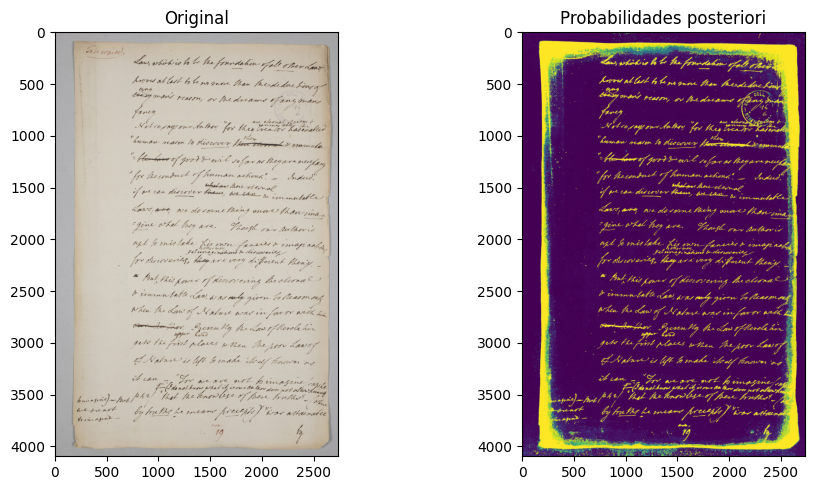

In [42]:
#Mostramos la imagen original y el mapa de probabilidades
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(imagen)
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(posterior_img, cmap='viridis_r')
plt.title('Probabilidades posteriori')

plt.tight_layout()
plt.show()

**Apartado b**

Sí, como podemos ver en la imagen de la derecha podemos interpretar distintas regiones según su grupo. Podemos ver como la mixtura ha separado dos claros grupos, en amarillo la letra y los bordes del papel y en morado la zona de papel que no está escrita.

**Apartado c**

In [17]:
from PIL import Image
import numpy as np
# Cargar imagen
img_s = Image.open('S.png').convert('L')
# Convertir objeto imagen a array numpy
img_s_arr = np.asarray(img_s)
#Obtenemos número de filas, columnas y canales de color
fil = img_s_arr.shape[0]
col = img_s_arr.shape[1]

In [18]:
#Obtenemos las coordenadas de píxeles negros
coords = np.column_stack(np.where(img_s_arr < 128))

#Seleccionamos 10,000 muestras negras
np.random.seed(0)
coords_muestra = coords[np.random.choice(coords.shape[0], 10000)]

In [19]:
#Entrenamos GMM con 64 componentes
from sklearn.mixture import GaussianMixture

gmm_s = GaussianMixture(n_components=64, covariance_type='full', random_state=0)
gmm_s.fit(coords_muestra)

GaussianMixture(n_components=64, random_state=0)

In [20]:
#Calculamos los logaritmos de las densidades de probabilidad para cada píxel de la imagen
grid_x, grid_y = np.meshgrid(np.arange(col), np.arange(fil))
grid_coords = np.column_stack([grid_y.ravel(), grid_x.ravel()])
log_probs = gmm_s.score_samples(grid_coords)
log_probs_img = log_probs.reshape(fil, col)

#Generamos 1000 muestras nuevas de la distribución aprendida
samples, _ = gmm_s.sample(1000)
medias = gmm_s.means_

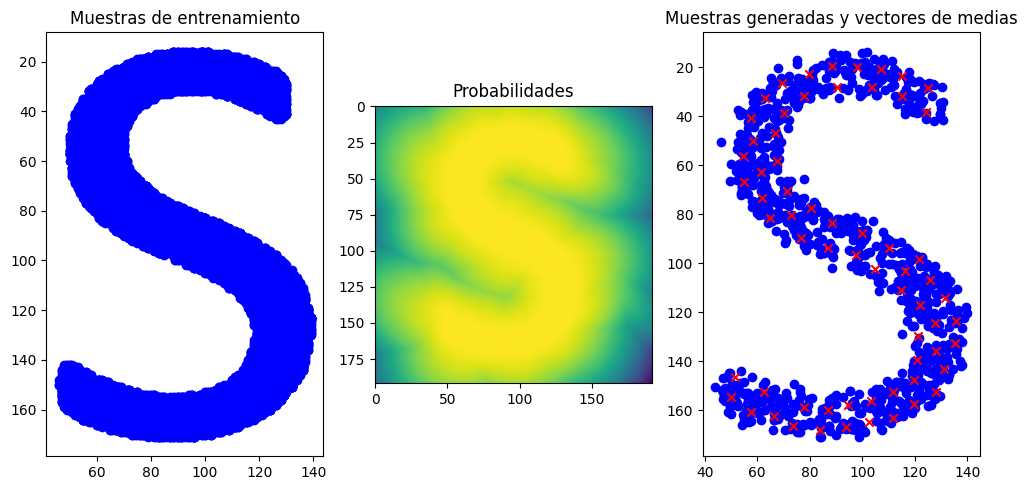

In [21]:
#Generamos la figura con las tres subfiguras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

#Subfigura 1
plt.subplot(1, 3, 1)
plt.scatter(coords_muestra[:, 1], coords_muestra[:, 0], color='blue')
plt.gca().invert_yaxis()
plt.title('Muestras de entrenamiento')

# Subfigura 2
plt.subplot(1, 3, 2)
plt.imshow(log_probs_img, cmap='viridis')
plt.title('Probabilidades')

# Subfigura 3
plt.subplot(1, 3, 3)
plt.scatter(samples[:, 1], samples[:, 0], color='blue')
plt.scatter(medias[:, 1], medias[:, 0], marker='x', color='red')
plt.gca().invert_yaxis()
plt.title('Muestras generadas y vectores de medias')

plt.tight_layout()
plt.show()

**Apartado d**

Como podemos ver en la imagen, la mixtura gaussiana ha conseguido aprender bastante bien el conjunto de datos. Ya en el mapa de las probabilidades podemos ver como el modelo ha capturado bien la forma de la S. Además las medias se reparten por todo el contorno de la S, lo que significa que el modelo ha aprendido cómo está dibujada la letra S, no solo punto por punto, sino la forma general, pudiendo así reconocer nuevas letras S.